# Proyek Klasifikasi Gambar: Brain Tumor MRI Multi Class Dataset
- **Nama:** ALVINA AULIA NISA
- **Email:** alvinaaulians@gmail.com
- **ID Dicoding:** alvinaaulianisa

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from google.colab import files

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alvinaaulianisa","key":"563f61499ee8701869000c7e54afaccf"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d maxwellbernard/brain-tumor-mri-multi-class-dataset
!unzip brain-tumor-mri-multi-class-dataset.zip -d brain-tumor-mri-multi-class-dataset

Streaming output truncated to the last 5000 lines.
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1329.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1330.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1331.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1332.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1333.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1334.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1335.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Orvile_meningioma_1336.jpg  
  inflating: brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningio

In [6]:
def count_images_in_dataset(dataset_dir, extensions=('.jpg', '.jpeg', '.png')):
    total = 0
    class_counts = {}

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(extensions)
            ]
            count = len(image_files)
            class_counts[class_name] = count
            total += count

    return total, class_counts

dataset_path = '/content/brain-tumor-mri-multi-class-dataset/multi_class_dataset'

total_images, per_class = count_images_in_dataset(dataset_path)

print(f"Total gambar di dataset: {total_images}")
for cls, count in per_class.items():
    print(f" - {cls}: {count} gambar")

Total gambar di dataset: 16269
 - glioma: 3325 gambar
 - pituitary: 2974 gambar
 - healthy: 6704 gambar
 - meningioma: 3266 gambar


### Data Preprocessing

#### Split Dataset

In [7]:
base_dir = "brain_tumor_split"

for split in ['train', 'val', 'test']:
    for cls in ['glioma', 'healthy', 'meningioma', 'pituitary']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

def split_data(cls_name, src_dir, train_size=0.7, val_size=0.15):
    files = os.listdir(src_dir)
    np.random.shuffle(files)

    total = len(files)
    train_len = int(train_size * total)
    val_len = int(val_size * total)

    for i, file in enumerate(files):
        src_path = os.path.join(src_dir, file)
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        if i < train_len:
            dst = os.path.join(base_dir, 'train', cls_name, file)
        elif i < train_len + val_len:
            dst = os.path.join(base_dir, 'val', cls_name, file)
        else:
            dst = os.path.join(base_dir, 'test', cls_name, file)
        shutil.copy(src_path, dst)

original_dir = '/content/brain-tumor-mri-multi-class-dataset/multi_class_dataset'
for cls in ['glioma', 'healthy', 'meningioma', 'pituitary']:
    split_data(cls, os.path.join(original_dir, cls))

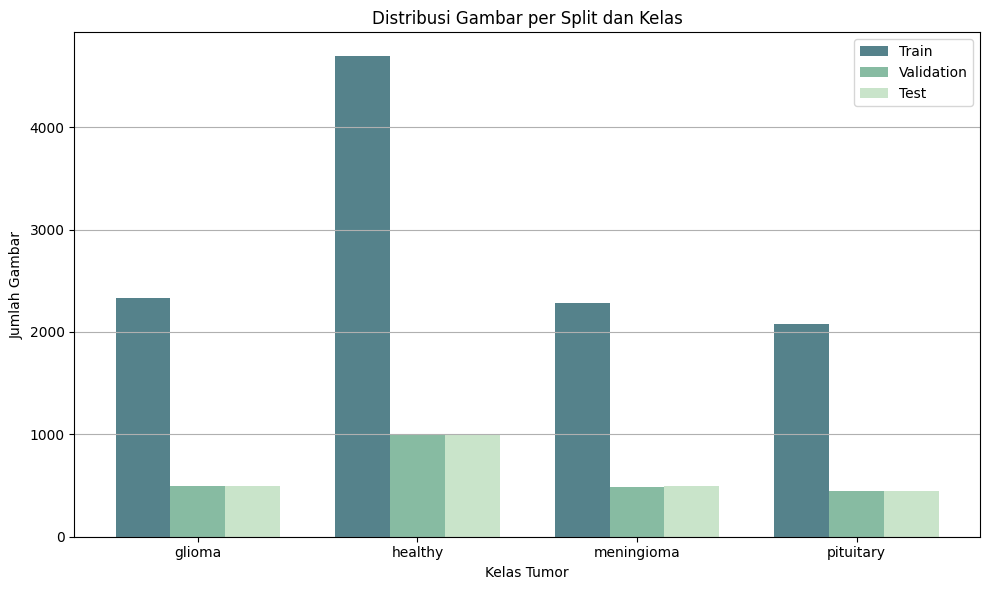

In [8]:
base_dir = "brain_tumor_split"
splits = ['train', 'val', 'test']
class_labels = ['glioma', 'healthy', 'meningioma', 'pituitary']

counts = {split: [] for split in splits}

for split in splits:
    for cls in class_labels:
        dir_path = os.path.join(base_dir, split, cls)
        count = len([
            f for f in os.listdir(dir_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        counts[split].append(count)

x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, counts['train'], width, label='Train', color='#55828b')
plt.bar(x,         counts['val'],   width, label='Validation', color='#87bba2')
plt.bar(x + width, counts['test'],  width, label='Test', color='#c9e4ca')

plt.xticks(x, class_labels)
plt.xlabel("Kelas Tumor")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar per Split dan Kelas")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

####Augmentasi

In [9]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11386 images belonging to 4 classes.
Found 2438 images belonging to 4 classes.
Found 2445 images belonging to 4 classes.


## Modelling

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,602,884 (13.74 MB)

 Trainable params: 3,601,924 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.9767 - loss: 0.0651 - val_accuracy: 0.9582 - val_loss: 0.1269
Epoch 2/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.9834 - loss: 0.0509 - val_accuracy: 0.9598 - val_loss: 0.1276
Epoch 3/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.9875 - loss: 0.0368 - val_accuracy: 0.9660 - val_loss: 0.1082
Epoch 4/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9897 - loss: 0.0303 - val_accuracy: 0.9647 - val_loss: 0.1185
Epoch 5/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.9866 - loss: 0.0383 - val_accuracy: 0.9561 - val_loss: 0.1393
Epoch 6/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - accuracy: 0.9860 - loss: 0.0357 - val_accuracy: 0.9553 - val_loss: 0.1516


## Evaluasi dan Visualisasi

In [13]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_gen)

print(f"Akurasi Train Set: {train_acc*100:.2f}%")
print(f"Akurasi Validasi Set: {val_acc*100:.2f}%")
print(f"Akurasi Test Set: {test_acc*100:.2f}%")

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - accuracy: 0.9354 - loss: 0.2099
Akurasi Train Set: 98.44%
Akurasi Validasi Set: 95.53%
Akurasi Test Set: 96.20%


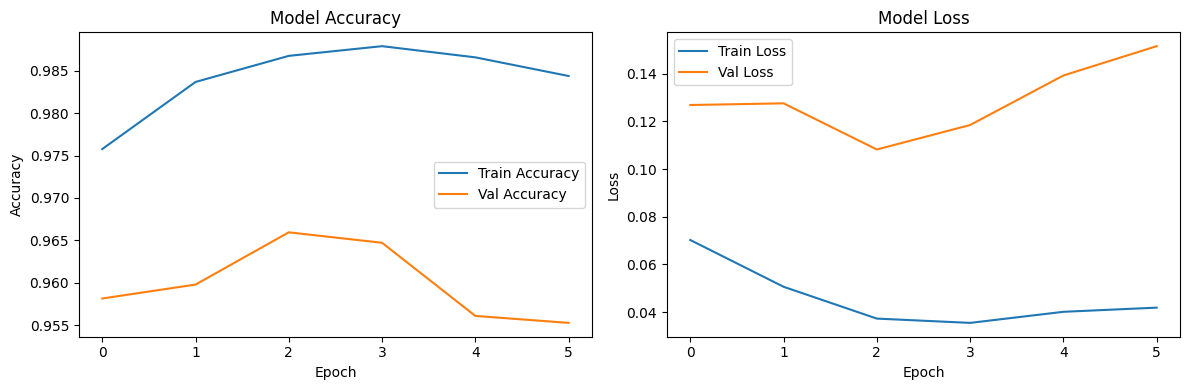

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 382ms/step


<Figure size 600x500 with 0 Axes>

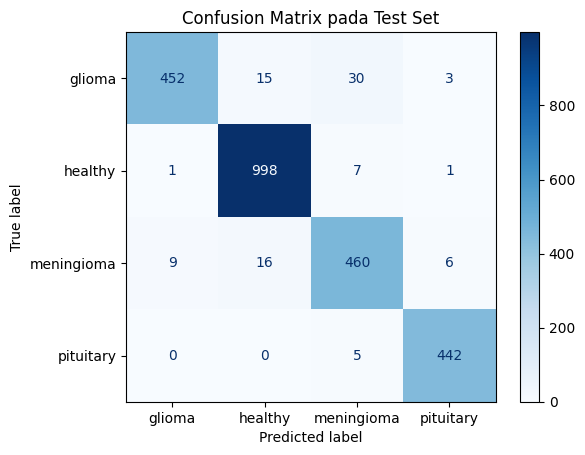


Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.90      0.94       500
     healthy       0.97      0.99      0.98      1007
  meningioma       0.92      0.94      0.93       491
   pituitary       0.98      0.99      0.98       447

    accuracy                           0.96      2445
   macro avg       0.96      0.96      0.96      2445
weighted avg       0.96      0.96      0.96      2445



In [15]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_gen.classes

index_to_label = {
    0: 'glioma',
    1: 'healthy',
    2: 'meningioma',
    3: 'pituitary'
}
class_names = [index_to_label[i] for i in range(len(index_to_label))]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix pada Test Set")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

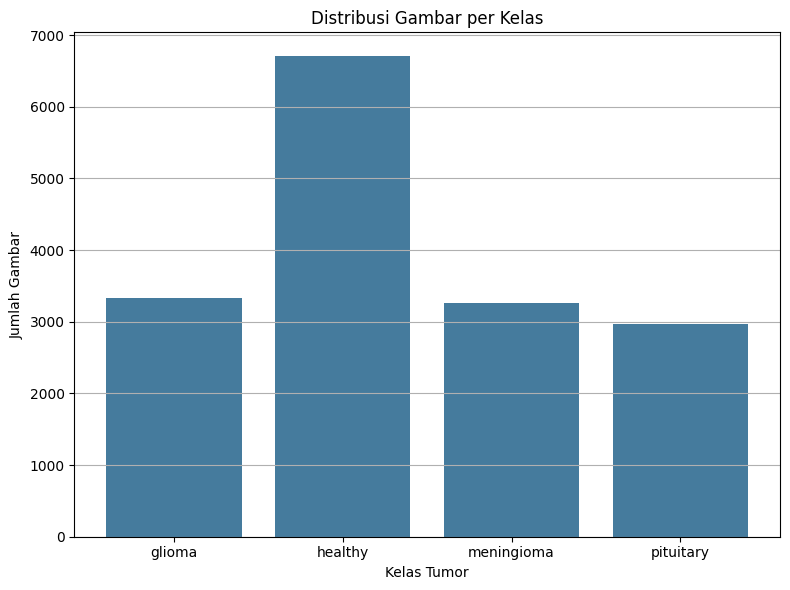

In [16]:
base_dir = "brain_tumor_split"
splits = ['train', 'val', 'test']
original_class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

class_counts = {cls_name: 0 for cls_name in original_class_names}

for split in splits:
    for cls_name in original_class_names:
        dir_path = os.path.join(base_dir, split, cls_name)
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[cls_name] += count

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='#457b9d')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas Tumor")
plt.ylabel("Jumlah Gambar")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Konversi Model

In [17]:
os.makedirs("saved_model", exist_ok=True)

In [18]:
model.export("saved_model/brain_tumor_model")

Saved artifact at 'saved_model/brain_tumor_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139693018324560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018326288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018328976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018325904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018325712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018328016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018328592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018330128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018330512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693018328784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/brain_tumor_model")
tflite_model = converter.convert()

with open("saved_model/brain_tumor_model.tflite", "wb") as f:
    f.write(tflite_model)

In [20]:
!pip install tensorflowjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/brain_tumor_model \
    saved_model/tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-15 05:02:01.072235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747285321.105822   32601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Inference (Optional)

In [21]:
model = tf.saved_model.load('/content/saved_model')

In [22]:
infer = model.signatures['serving_default']

img_path = '/content/brain-tumor-mri-multi-class-dataset/multi_class_dataset/meningioma/Fernando_Feltrin_meningioma_138.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [23]:
predictions = infer(tf.convert_to_tensor(img_array))

predicted_class = np.argmax(predictions['output_0'].numpy())
class_labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
print(f"Prediksi Kelas: {class_labels[predicted_class]}")
print(f"Probabilitas Prediksi: {np.max(predictions['output_0'].numpy()) * 100:.2f}%")

Prediksi Kelas: meningioma
Probabilitas Prediksi: 99.96%
